## Imports

In [81]:
import numpy as np
import math
import datascience
import scipy
from datascience import *
from scipy import *
from scipy.signal import find_peaks, find_peaks_cwt, savgol_filter
import sklearn
from sklearn.metrics import mean_absolute_error
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.rcParams["figure.figsize"] = (10,7)
import time
import lmfit
from lmfit import minimize
from lmfit import Minimizer, Parameters


from lmfit.models import LorentzianModel

## Data
`Peak_Interval_List.csv` and `Ig110postbakemap9476.CSV` from
Graphite Raman Mapping (Project 31) on Box.

x,y
500,1.11038
500.137,0.985766
500.274,0.951698
500.411,0.957243
500.547,0.893833
500.684,0.883336
500.821,0.872838
500.958,0.889714
501.095,0.849866
501.232,0.835878


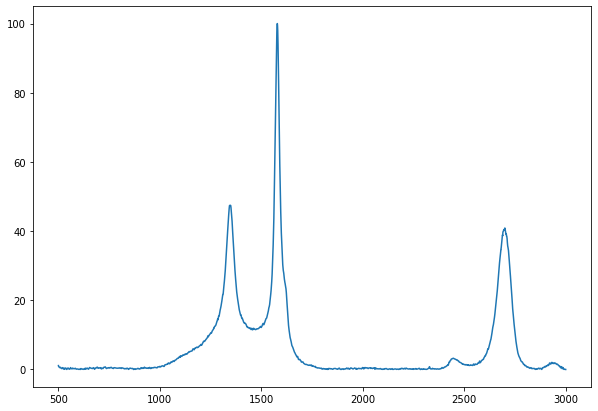

In [82]:
peak_intervals = Table().read_table("new_peak_list.csv")
sample_spectrum = Table().read_table("JQ2a2_16.csv")
#sample_spectrum = Table().read_table("Ig110postbakemap9476.CSV")
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))
sample_spectrum

In [83]:
model = 

SyntaxError: invalid syntax (1821345968.py, line 1)

In [84]:
peak_intervals

Peak Name,Peak Number,Optional?,Min Bound X,Max Bound X
Pre-D,1,Yes,1000,1320
D,2,No,1340,1360
D-G shoulder,3,Yes,1370,1550
G,4,No,1560,1600
D' shoulder,5,No,1600,1630
T+D,6,Yes,2300,2500
G'_3Da,7,No,2640,2690
G'_2D,8,No,2680,2720
G'_3DB,9,No,2700,2740
D'+D,10,No,2850,2950


## Driver Function
`spectrum`: table with two columns: x and y <br>  
`num_peaks`: int, how many peaks to fit with <br>  
`baseline_deg`: degree of polynomial to fit baseline with  <br>  
`baseline_tol`: tolerance to stop baseline iteration  <br>  
`peak_type`: lorentz/gaussian, later add option to choose others (examples in the matlab, should be able to express with the same parameters) <br>  
`error`: MAE, MSE, etc. <br>  
`tolerance`: to within what error should we fit <br>  
`num_iterations`: how many iterations should we go through <br>  
`window_len`: length of savitsky-golay filter window <br>  
`polyorder`: order of polynomial to fit samples in savitsky-golay

In [85]:
lambda_1 = 0.05
lambda_2 = 0.05

In [99]:
def fit_spectrum(spectrum, num_peaks, baseline_deg, baseline_tol, peak_type, error_type, tolerance, num_iterations, window_len, polyorder):
    start_time = time.time() # unit: seconds
    # Restrict data x to 500-3000
    restricted_spectrum = spectrum.where("x", are.between_or_equal_to(500, min(3000, max(spectrum.column("x")))))
    # Smooth signal with Savitsky-Golay filter
    smoothed_y = scipy.signal.savgol_filter(restricted_spectrum.column("y"), window_len, polyorder)
    smoothed_spectrum = Table().with_columns("x", restricted_spectrum.column("x"), "y", smoothed_y)
    # Remove baseline
    spectrum_baseline_removed = remove_baseline(smoothed_spectrum, baseline_deg, baseline_tol)
    # Normalize spectrum
    normalized_y = ((spectrum_baseline_removed.column("y") - min(spectrum_baseline_removed.column("y")))
                    / (max(spectrum_baseline_removed.column("y")) - min(spectrum_baseline_removed.column("y"))))
    normalized_spectrum = Table().with_columns("x", spectrum_baseline_removed.column("x"), "y", normalized_y)
    # Identify peaks
    # check peak interval - edit num_peaks
    detected_peaks = detect_peaks(normalized_spectrum, num_peaks)
    # Reconstruct spectra
    peaks = create_peaks(peak_type, detected_peaks)

    # Create loss function that we will optimize
    def error(guess_array):
        # first num_peaks elems are amp, next are cen, next are wid
        amp = guess_array[0:num_peaks]
        cen = guess_array[num_peaks:2*num_peaks]
        wid = guess_array[2*num_peaks:3*num_peaks]
        guess_peaks = Table().with_columns("Peak #", range(num_peaks),
                                          "amp", amp, "cen", cen, "wid", wid)
        reconstructed = reconstruct_spectrum(normalized_spectrum, guess_peaks)
        # choose error
        if error_type == "MAE":
            e = sklearn.metrics.mean_absolute_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MSE":
            e = sklearn.metrics.mean_squared_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MAPE":
            e = sklearn.metrics.mean_absolute_percentage_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "RMSPE":
            e = RMSPE(normalized_spectrum.column("y"), reconstructed)
        else:
            raise Exception("Error type not supported")
        print(e)
        return e
        return e #+ lambda_1 * (1 if guess_array[num_peaks + 8] < guess_array[num_peaks + 7] else 0) + lambda_2 * abs(guess_array[6] / guess_array[8] - 0.5)
    
    # change this from numpy appending to normal python list operations
    initial_guess = np.append(np.append(peaks.column("amp"), peaks.column("cen").astype(int)), peaks.column("wid"))

    # create bounds
    amp_bounds = [(0.0001, 300) for i in range(num_peaks)]
    min_x = peak_intervals.column("Min Bound X")
    max_x = peak_intervals.column("Max Bound X")
    cen_bounds = [(min_x[i], max_x[i]) for i in range(num_peaks)]
    wid_bounds = [(0.0001, 400) for i in range(num_peaks)]
    bounds = amp_bounds + cen_bounds + wid_bounds
    
    # ensure center of peak 9 > peak 8
    cons1 = {"type": "ineq", "fun": lambda arr: arr[num_peaks + 8] - arr[num_peaks + 7]}
    # upper bound for peak 7 : peak 9 (amplitude)
    cons2 = {"type": "ineq", "fun": lambda arr: arr[6] / arr[8] - 0.45}
    # lower bound for peak 7 : peak 9 (amplitude)
    cons3 = {"type": "ineq", "fun": lambda arr: -(arr[6] / arr[8]) + 0.55}
    constraints = [cons1, cons2, cons3]
    constraints_test = [cons1]
    
    initial_guess = np.asarray([7.37908, 34.97015, 3.65915, 36.15784, 4.22964, 2.89295, 5.91514, 17.67787, 10.7548, 2.4001,
                                1275.74783, 1348.01504, 1493.83166, 1581.71285, 1620.46057, 2456.79433, 2666.37302, 2694.74791, 2721.62489, 2940.27771,
                                215.7532, 44.50159, 92.21057, 23.70187, 24.28155, 67.71584, 59.9331, 47.47378, 40.57773, 58.14838])
    
    
    #original minimize call - commenting out for testing others
    #result_full = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=tolerance,
     #                                options={"maxiter": num_iterations})
    
"""
    # LMFIT minimize call
    # error is objective function
    # initial guess is parameters
    # default leastsq L-M fitting method
    fitter = Minimizer(error, initial_guess)
    print("fitting")
    min_res = fitter.minimize(method = "leastsq")
    print(min_res.success)
    print(min_res.params)
    return min_res
"""
    
    # LMFIT different approach
    out = minimize(error, initial_guess)

    
"""

    # LMFIT call
    model = LorentzianModel()
    params = model.guess(normalized_spectrum.column("y"), x=normalized_spectrum.column("x"))
    result = model.fit(normalized_spectrum.column("y"), params, x=normalized_spectrum.column("x"))
    print(result.fit_report())
    result.plot_fit()
    return 



    result = result_full.x
    
    # plot result
    result_matrix = Table().with_columns("Peak #", np.arange(num_peaks),
                                        "amp", result[0:num_peaks],
                                        "cen", result[num_peaks:2*num_peaks],
                                        "wid", result[2*num_peaks:3*num_peaks])
    print(result_matrix)
    reconstructed_y = reconstruct_spectrum(normalized_spectrum, result_matrix)
    
    guess_and_real = Table().with_columns("Real", normalized_y, "Reconstructed", reconstructed_y, "x", normalized_spectrum.column("x"))
    #guess_and_real.plot("x")
    
    
    # Temporary test code
    # Plotting individual peaks
    
    test_plot = guess_and_real
    #for i in range(num_peaks):
    #    parameters_i = result_matrix.row(i)
    #    amp_i = parameters_i.item("amp")
    #    cen_i = parameters_i.item("cen")
    #    wid_i = parameters_i.item("wid")
    #    peak_i = [lorentz(x, amp_i, cen_i, wid_i) for x in normalized_spectrum.column("x")]
    #    test_plot = test_plot.with_columns(f"Peak {i}", peak_i)
    # test_plot.plot("x")
    plots.plot(test_plot.column("x"), test_plot.column("Real"), label="Real")
    plots.plot(test_plot.column("x"), test_plot.column("Reconstructed"), label="Reconstructed")
    #for i in range(num_peaks):
    #    plots.plot(test_plot.column("x"), test_plot.column(f"Peak {i}"), label=f"Peak {i + 1}")
    plots.legend()
    
    
    
    end_time = time.time()
    print(f"Program runtime (minutes):  {(end_time - start_time) / 60}")
    
    print(error(result))
    return result_full
"""

'\n\n    # LMFIT call\n    model = LorentzianModel()\n    params = model.guess(normalized_spectrum.column("y"), x=normalized_spectrum.column("x"))\n    result = model.fit(normalized_spectrum.column("y"), params, x=normalized_spectrum.column("x"))\n    print(result.fit_report())\n    result.plot_fit()\n    return \n\n\n\n    result = result_full.x\n    \n    # plot result\n    result_matrix = Table().with_columns("Peak #", np.arange(num_peaks),\n                                        "amp", result[0:num_peaks],\n                                        "cen", result[num_peaks:2*num_peaks],\n                                        "wid", result[2*num_peaks:3*num_peaks])\n    print(result_matrix)\n    reconstructed_y = reconstruct_spectrum(normalized_spectrum, result_matrix)\n    \n    guess_and_real = Table().with_columns("Real", normalized_y, "Reconstructed", reconstructed_y, "x", normalized_spectrum.column("x"))\n    #guess_and_real.plot("x")\n    \n    \n    # Temporary test code\n   

In [87]:
# returns an array the same length as x
# fits points in spectrum x to polynomial of degree deg
# change tol to be for error between previous line and new line

# save old coeffs to compare polynomials on the same set of x values -> above/below tol
# try a value for tol - set a default
# doesn't really matter which error we use - use msre with a tolerance of 1% (or MRE)
# initial guess: fit line
# full=True allows us to access sum of squared residuals of the fit as well
def baseline(spectrum, deg, tol):
    s = spectrum
    e = float('inf')
    old_coef = None
    nrows = 0
    while(e > tol):
        # adding this condition to hopefully make stuff better
        if spectrum.num_rows == 0:
            break;
        print(e)
        # create fit line w/ np.polyfit & turn into a function w/ polyn
        coef = np.polyfit(spectrum.column("x"), spectrum.column("y"), deg, full=False)
        polyn = make_polynomial(coef, deg)
        # re-fit line to remaining points
        
        baseline_fit = spectrum.apply(polyn, "x")
        #plots.plot(spectrum.column("x"), spectrum.column("y"))
        
        #plots.plot(spectrum.column("x"), baseline_fit)
        # do error b/t previous line
        if type(old_coef) != type(None):
            #e = sklearn.metrics.mean_absolute_error(baseline_fit, spectrum.apply(make_polynomial(old_coef, deg), "y"))
            e = RMSPE(baseline_fit, spectrum.apply(make_polynomial(old_coef, deg), "x"))
        # remove any points above fit line
        spectrum = spectrum.with_column("baseline", baseline_fit)
        print(spectrum)
        wanted_indices_bool = spectrum.column("y") <= spectrum.column("baseline")
        wanted_indices = [i for i in range(len(wanted_indices_bool)) if wanted_indices_bool[i]]
        spectrum = spectrum.take(wanted_indices)
        # repeat until fitting error < tol or # points doesn't change
        old_coef = coef
        print("spectrum rows ", spectrum.num_rows)
        print("nrows ", nrows)
        # added condition so every single point isn't destroyed
        if abs(nrows - spectrum.num_rows) < 75:
            break
        if spectrum.num_rows == nrows:
            print("nrows exit")
            break
        nrows = spectrum.num_rows
    # changed spectrum
    baseline_ret = s.apply(polyn, "x")
    #plots.plot(s.column("x"), s.column("y"))
    #plots.plot(s.column("x"), baseline_ret)
    return baseline_ret

In [88]:
# takes in a table and returns a table w/ same columns & dimensions
def remove_baseline(spectrum, deg, tol):
    bl = baseline(spectrum, deg, tol)
    return Table().with_columns("x", spectrum.column("x"), "y", spectrum.column("y") - bl)

In [89]:
# returns a single-variable polynomial function of degree deg from coefficients coef
def make_polynomial(coef, deg):
    # takes in an array of x values and returns an array of y values of the same dimension
    def polyn(x):
        y = 0
        for i in range(deg + 1):
            y += pow(x, deg - i) * coef[i]
        return y
    return polyn

In [90]:
# returns an array with num_peaks x-values set to the midpoint of their bounds
# add option to remove peaks that are not required for lower num_peaks
def detect_peaks(spectra, num_peaks):
    midpoints = (peak_intervals.column("Min Bound X") + peak_intervals.column("Max Bound X")) / 2
    return midpoints

In [91]:
# returns a matrix of initial guesses
# dimensions 4 x num_peaks (4 = num parameters - x)
def create_peaks(peak_type, detected_peaks):
    if peak_type == "lorentz":
        parameter_matrix = Table(["Peak #", "amp", "cen", "wid"])
        for i in np.arange(len(detected_peaks)):
            amp = guess_amp()
            cen = detected_peaks[i]
            wid = guess_wid()
            parameter_matrix.append([i, amp, cen, wid])
        return parameter_matrix
    elif peak_type == "gaussian":
        return False

In [92]:
def guess_amp():
    return 5

In [93]:
def guess_wid():
    return 10

In [94]:
# x - values where the function is calculated
# y_0 - baseline
# amp - area
# cen - peak's center position
# wid - controls full width half maximum of the function
def lorentz(x, amp, cen, wid):
    return (amp/np.pi)*(wid / ((x - cen) ** 2 + wid ** 2))

In [95]:
# x - values where the function is calculated
# y_0 - baseline
# height - height of peak
# center - center of peak
# std - standard deviation
def gaussian(x, y_0, amp, cen, wid):
    std=wid/2.355
    return (amp / (std * np.sqrt(2*np.pi))) * (np.e ** -(((x - center) ** 2)) / 2 * std ** 2) + y_0

In [96]:
# returns an array of y values for each x value in spectrum. y values obtained using peak_parameters
def reconstruct_spectrum(spectrum, peak_parameters):
    def reconstruct_sum(x):
        peaks = peak_parameters.with_columns("x", [x for i in range(peak_parameters.num_rows)])
        sum_peaks = peaks.apply(lorentz, "x", "amp", "cen", "wid")
        return np.sum(sum_peaks)
    reconstructed = [reconstruct_sum(x) for x in spectrum.column("x")]
    return reconstructed

In [97]:
def RMSPE(y_true, y_pred):
    EPSILON = 1e-10
    return (np.sqrt(np.mean(np.square((y_true + EPSILON - y_pred) / y_true + EPSILON)))) * 100

## Demo

fit_spectrum(spectrum, num_peaks, baseline_deg, baseline_tol, peak_type, error_type, tolerance, num_iterations, window_len, polyorder)

In [100]:
x = fit_spectrum(sample_spectrum, 10, 1, 0.01, "lorentz", "MAPE", None, 10000000, 27, 2)

inf
x       | y        | baseline
500     | 1.02208  | 6.02185
500.137 | 0.999696 | 6.02187
500.274 | 0.977967 | 6.02189
500.411 | 0.956895 | 6.02191
500.547 | 0.936481 | 6.02193
500.684 | 0.916725 | 6.02196
500.821 | 0.897628 | 6.02198
500.958 | 0.879188 | 6.022
501.095 | 0.861407 | 6.02202
501.232 | 0.844284 | 6.02205
... (18261 rows omitted)
spectrum rows  13742
nrows  0
inf
x       | y        | baseline
500     | 1.02208  | 0.823651
500.137 | 0.999696 | 0.823669
500.274 | 0.977967 | 0.823688
500.411 | 0.956895 | 0.823706
500.547 | 0.936481 | 0.823725
500.684 | 0.916725 | 0.823743
500.821 | 0.897628 | 0.823761
500.958 | 0.879188 | 0.82378
501.095 | 0.861407 | 0.823798
501.232 | 0.844284 | 0.823817
... (13732 rows omitted)
spectrum rows  9610
nrows  13742
534.7249210521891
x       | y        | baseline
501.505 | 0.812011 | 0.317741
501.642 | 0.796862 | 0.31774
501.779 | 0.782371 | 0.317738
501.916 | 0.774402 | 0.317736
502.053 | 0.762265 | 0.317735
502.189 | 0.750042 | 0.317733
502.3

AttributeError: 'MinimizerResult' object has no attribute 'params'

In [ ]:
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))

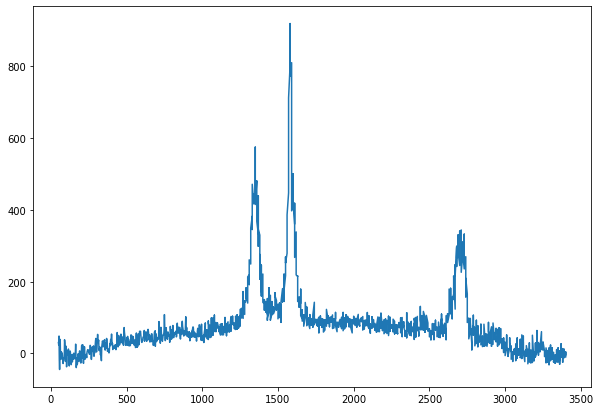

In [89]:
y_offset = sample_spectrum.apply(lambda x: -0.00002 * (x-1700)**2 + 40, "x")
new_y = sample_spectrum.column("y") + y_offset
test_spectrum = Table().with_columns("x", sample_spectrum.column("x"), "y", new_y)
sample_spectrum = test_spectrum
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))

In [90]:
restricted_spectrum = sample_spectrum.where("x", are.between_or_equal_to(500, min(3000, max(sample_spectrum.column("x")))))
# Smooth signal with Savitsky-Golay filter
smoothed_y = scipy.signal.savgol_filter(restricted_spectrum.column("y"), 27, 2)
smoothed_spectrum = Table().with_columns("x", restricted_spectrum.column("x"), "y", smoothed_y)

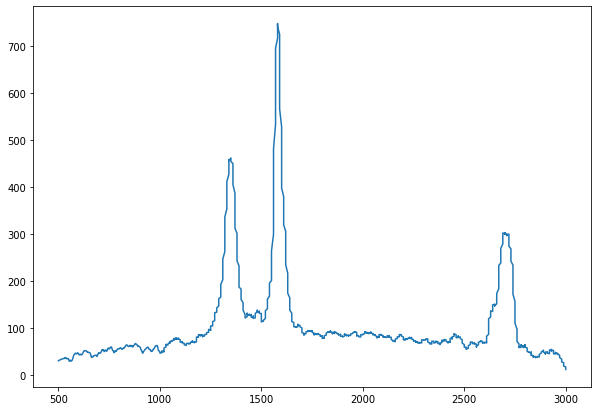

In [91]:
plots.plot(smoothed_spectrum.column("x"), smoothed_spectrum.column("y"))

In [92]:
sample_spectrum = smoothed_spectrum

inf
x    | y       | baseline
500  | 30.2582 | 25.0327
501  | 30.7722 | 25.2176
503  | 31.2594 | 25.587
505  | 31.7197 | 25.9559
507  | 32.1531 | 26.3241
509  | 32.5597 | 26.6918
511  | 32.9394 | 27.0589
513  | 33.2923 | 27.4254
515  | 33.6183 | 27.7913
517  | 33.9174 | 28.1567
... (1290 rows omitted)
spectrum rows  1001
nrows  0
inf
x    | y       | baseline
550  | 33.5744 | 32.6162
552  | 30.9592 | 32.8217
554  | 29.2889 | 33.0269
555  | 29.7042 | 33.1293
557  | 31.3065 | 33.3339
559  | 31.1611 | 33.5382
561  | 29.9727 | 33.7422
563  | 29.5848 | 33.9458
565  | 30.7169 | 34.149
567  | 31.0827 | 34.352
... (991 rows omitted)
spectrum rows  611
nrows  1001
45.726052983374835
x    | y       | baseline
552  | 30.9592 | 26.0741
554  | 29.2889 | 26.2745
555  | 29.7042 | 26.3745
557  | 31.3065 | 26.5744
559  | 31.1611 | 26.774
561  | 29.9727 | 26.9732
563  | 29.5848 | 27.1721
565  | 30.7169 | 27.3706
567  | 31.0827 | 27.5688
569  | 32.97   | 27.7667
... (601 rows omitted)
spectrum rows  277


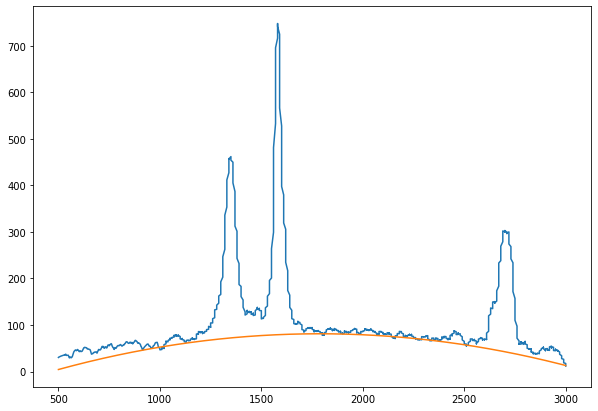

In [98]:
#y_offset = sample_spectrum.apply(lambda x: -0.00002 * (x-1700)**2 + 40, "x")
#new_y = sample_spectrum.column("y") + y_offset
#test_spectrum = Table().with_columns("x", sample_spectrum.column("x"), "y", new_y)
test_spectrum = smoothed_spectrum

kachow = baseline(test_spectrum, 2, .01)

plots.plot(sample_spectrum.column("x"), test_spectrum.column("y"))
plots.plot(sample_spectrum.column("x"), kachow)